In [1]:
# Intialize the tensorflow-gpu <-> physical matching
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
##############################3 Insert model and Data Properties
### be careful when calculating test accuracy, make sure labels_map is same as train phase and test phase(here)
model_data_argu = {'label': "Mask", 'dsize': (64,64), 'model_name': "model_mask_cnn", "labels_map": {'m0': 0, 'm1': 1}}

In [6]:
# Load Model (Test)
from tensorflow.keras.models import load_model
import utils.xai_viz
from utils.xai_viz import explainable_model
import importlib
from model.model_cnn import model_cnn
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import random
from load.load_data import load_mydata

myloader = load_mydata()
X_my_test, Y_my_test = myloader.load_test_data(classifier_label=model_data_argu['label'], dsize=model_data_argu['dsize'], comp_ratio=4)
print("My Test set is ", len(Y_my_test))

X_test = np.array(X_my_test)/255.0
labels_map=model_data_argu["labels_map"]

Y_my_test = np.array(list(map(lambda x: labels_map[x], Y_my_test)))
Y_test = to_categorical(np.array(Y_my_test))
print(labels_map)

Test data folder lists are..
20211012_center_belt_nomask_minseok1
20211012_center_unbelt_nomask_minseok1
20211015_center_belt_mask_yukhyun1
20211015_center_unbelt_mask_sungwook1
20211015_center_unbelt_mask_yukhyun1
20211015_center_unbelt_nomask_sungwook1
20211015_center_unbelt_nomask_sungwook2
20211015_center_unbelt_nomask_yukhyun1
20211015_close_unbelt_nomask_sungwook1
20211017_center_belt_mask_yukhyun1
20211017_center_belt_nomask_yukhyun1
20211017_center_unbelt_mask_sungwook1
20211017_center_unbelt_nomask_sungwook1
20211019_center_belt_mask_juwon1
20211019_center_belt_mask_juwon2
20211019_center_belt_mask_juwon3
20211019_center_belt_nomask_juwon1
20211019_center_belt_nomask_juwon2
20211019_center_unbelt_mask_juwon3
20211019_center_unbelt_nomask_juwon1
20211019_close_belt_mask_juwon1
20211019_close_unbelt_mask_juwon1
20211019_far_belt_mask_juwon1
20211019_far_unbelt_mask_juwon1
20211019_phone_belt_mask_juwon1
20211019_phone_unbelt_mask_juwon1
20211020_center_belt_mask_sujin1
20211020_

Test data Loading with Mask: 1819it [00:02, 675.60it/s]


My Test set is  467
{'m0': 0, 'm1': 1}


In [7]:
print(X_test.shape, Y_test.shape)

(467, 64, 64, 3) (467, 2)


In [8]:
model_load = load_model("./ckpt/"+model_data_argu["model_name"])
xai = explainable_model(model_load)

Model: "mask_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
1st_conv (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
1st_relu (ReLU)              (None, 64, 64, 64)        0         
_________________________________________________________________
1st_maxpool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
2nd_conv (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
2nd_relu (ReLU)              (None, 32, 32, 128)       0         
_________________________________________________________________
2nd_maxpool (MaxPooling2D)   (None, 16, 16, 128)   

In [9]:
X_pred=model_load.predict(X_test)
# Test using X_test data
def score(preds, labels):
    ret=0
    for pred, label in zip(preds, labels):

        pred_idx = np.argmax(pred)
        label_idx = np.argmax(label)

        if (pred_idx == label_idx):
            ret+=1

    ret = ret / len(preds)
    return ret

print("Test Predict is: {}%".format(score(X_pred, Y_test)*100))

Test Predict is: 99.14346895074947%


[-1.3173137  1.6670159]


Text(0.5, 1.0, 'Predicted 1 as 1.7fprob,  Label(GT): 1')

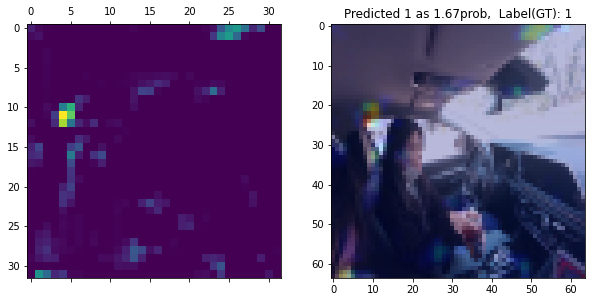

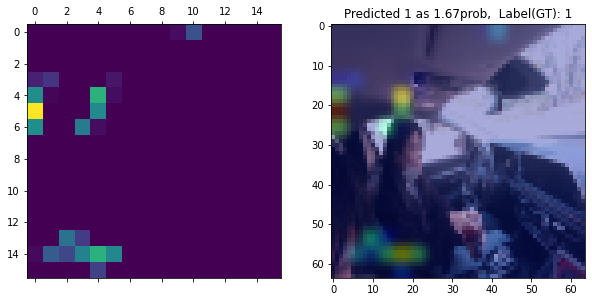

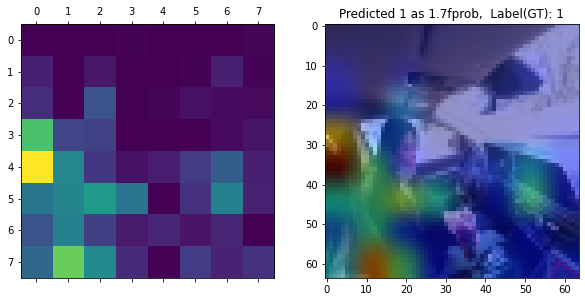

In [14]:
# labels_map={'c5': 0, 'c0': 1, 'c6': 2, 'c1': 3, 'c7': 4}
#2. (모델2: OOP + phoning**) 기존 오픈데이터셋의 라벨링 활용 가능 safe driving(c0), reaching behind(c7)
#                           ,phoning(c2,c4), texting(c1,c3)은 휴대폰 하고 있는 것으로 퉁쳐서 c1으로 클래스 구분하자
#                           -추가로 데이터 추가하고 클래스가 없는 too close(c5) / too far(c6)는 데이터 만들어야 겠네

for pick, i in enumerate(Y_test):
    if ( (np.argmax(i)==1) and (np.argmax(X_pred[pick])== np.argmax(i))):
        print(X_pred[pick])
        break


heatmap = xai.explainable_model(X_test[pick], "2nd_relu", alpha=0.4)
fig_title = "Predicted {} as {:.2f}prob".format(np.argmax(X_pred[pick]) , np.max(X_pred[pick])) + ",  Label(GT): {}".format(np.argmax(Y_test[pick]))
plt.title(fig_title)
heatmap = xai.explainable_model(X_test[pick], "3rd_conv", alpha=0.6)
fig_title = "Predicted {} as {:.2f}prob".format(np.argmax(X_pred[pick]) , np.max(X_pred[pick])) + ",  Label(GT): {}".format(np.argmax(Y_test[pick]))
plt.title(fig_title)
heatmap = xai.explainable_model(X_test[pick], "3rd_maxpool", alpha=0.8)
fig_title = "Predicted {} as {:.2}fprob".format(np.argmax(X_pred[pick]) , np.max(X_pred[pick])) + ",  Label(GT): {}".format(np.argmax(Y_test[pick]))
plt.title(fig_title)


AttributeError: 'Model' object has no attribute 'history'

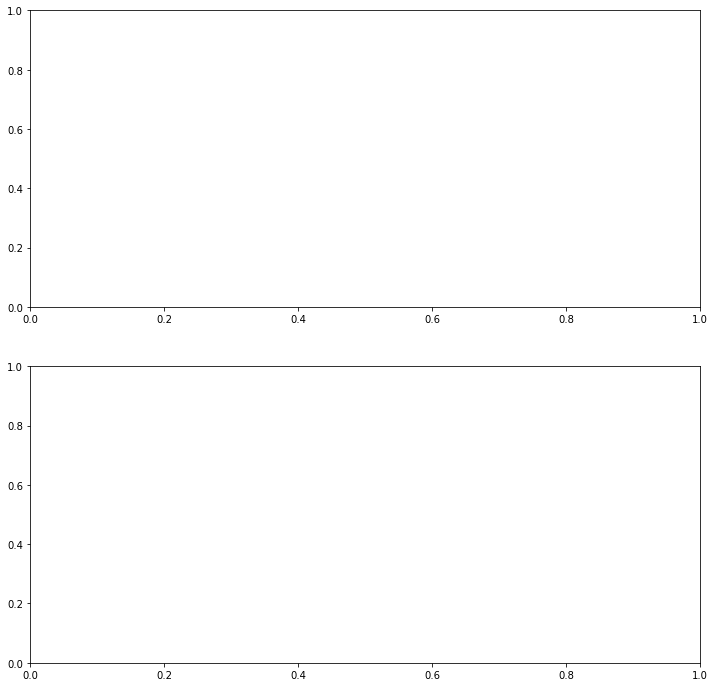

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
ax1.plot(model_load.history['loss'], color='b', label='Traing loss')
ax1.plot(model_load.history['val_loss'], color='r', label='Validation loss')
ax1.legend()
ax1.grid()

ax2.plot(model_load.history['acc'], color='b', label='Traing acc')
ax2.plot(model_load.history['val_acc'], color='r', label='Validation acc')
ax2.legend()
ax2.grid()

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(12,6))
ax1.plot(history.history['auc'], color='b', label='Traing auc')
ax1.plot(history.history['val_auc'], color='r', label='Validation auc')
ax1.legend()
ax1.grid()

In [ ]:
model_load[histor]